# Lab 8: CNN Tuning and Visualization

## Install and Update Packages

In [1]:
!pip install wandb --upgrade
!pip install grad-cam
!pip install matplotlib --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 78.9 MB/s eta 0:00:00
  Attempting uninstall: wandb
    Found existing installation: wandb 0.18.7
    Uninstalling wandb-0.18.7:
      Successfully uninstalled wandb-0.18.7
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39588 sha256=9f9cfae2be192ac4cac7c5825790fd1030fa43d47dc9f503bc5f75d3a8ac3c7b
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 105.1 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.0
    Uninstalling matplotlib-3.8.0:
      Successfully uninstalled matplotlib-3.8.0


## Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
root_dir = '/content/gdrive/My Drive/'

Mounted at /content/gdrive


## Import Modules

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data.sampler import Sampler
from torch.utils.data.dataset import Subset
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
from multiprocessing import cpu_count
from sklearn.metrics import classification_report, cohen_kappa_score
from collections import Counter, OrderedDict, defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time
import os
import copy
import csv
import wandb
from pytorch_grad_cam import GradCAM

## Basic Configurations

In [4]:

wandb.init(project="lABe")
# Set up the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Get the number of CPU threads
threads = cpu_count()
print(f"Number of CPU threads available: {threads}")



wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Using device: cuda:0
Number of CPU threads available: 8


## Preprocess Data

### Fetch the Dataset

In [5]:
!unzip -q "$root_dir""lidar_dataset.zip"
data_dir = '/content/dataset/'

mode = 'train'

###Compute Mean and Standard Deviation for Normalization

In [6]:
def computeDatasetStats(loader):
    mean, std  = 0, 0
    samples = 0.
    for images, _ in loader:
        mean += torch.mean(images, dim=(0,2,3))
        std += torch.std(images, dim=(0,2,3))
        samples += 1
    mean /= samples
    std /= samples
    return mean, std

data_transforms = transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor()
        ])
train_data = datasets.ImageFolder(os.path.join(data_dir,'train'), data_transforms)
train_dataloader = DataLoader(train_data, batch_size=1024, num_workers=1)

mean, std = computeDatasetStats(train_dataloader)

###Define and Apply Transformations

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data = {x: datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x])
            for x in ['train','test']}

data_sizes = {x: len(data[x]) for x in ['train','test']}

class_names = data['train'].classes
num_classes = len(class_names)

###Split Data into Training and Validation Sets

In [8]:
train_data_len = int(0.8*data_sizes['train'])
val_data_len = data_sizes['train']-train_data_len
data['train'], data['val'] = random_split(data['train'], (train_data_len,val_data_len))
data_sizes['train'] = train_data_len
data_sizes['val'] = val_data_len

### Sample and Load the Datasets

In [9]:
class ImbalancedDatasetSampler(Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
    Adapted From:
        https://github.com/ufoym/imbalanced-dataset-sampler
    """

    def __init__(self, dataset, indices=None, num_samples=None):
        # if indices is not provided,
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices
        # if num_samples is not provided,
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
        # distribution of classes in the dataset
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        dataset_type = type(dataset)
        if dataset_type is datasets.MNIST:
            return dataset.train_labels[idx].item()
        elif dataset_type is datasets.ImageFolder:
            return dataset.imgs[idx][1]
        elif dataset_type is Subset:
            return dataset[idx][1]
        else:
            raise NotImplementedError

    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
                    self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples


samples = {x: max(Counter((lbl for _,lbl in data[x])).values())*num_classes
                for x in ['train','val']}
samples['test'] = max(Counter((data['test'].targets)).values())*num_classes
samplers = {x: ImbalancedDatasetSampler(data[x], num_samples=samples[x])
                for x in ['train','val','test']}
dataloaders = {x: DataLoader(data[x], batch_size=128, num_workers=1, sampler=samplers[x])
                for x in ['train','val','test']}

## Or Fetch and Preprocess Test Data (to Evaluate Pretrained Models)

In [10]:
test_data_dir = '/content/dataset/test/'

data_transforms = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
        ])
test_data = datasets.ImageFolder(test_data_dir, data_transforms)
class_names = test_data.classes

test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True)
mode = 'test'

# Define the Network Architecture
### **Note:** Re-run this code cell each time you want to train the network from scratch!!

In [12]:
class LiNet(nn.Module):
    def __init__(self):
        super(LiNet, self).__init__()
        self.features = nn.Sequential(OrderedDict([
                            ('conv0', nn.Conv2d(1, 6, 9)),
                            ('relu0', nn.ReLU()),
                            ('pool0', nn.AvgPool2d(2)),
                            ('bn0', nn.BatchNorm2d(6)),
                            ('conv1', nn.Conv2d(6, 12, 9)),
                            ('relu1', nn.ReLU()),
                            ('pool1', nn.AvgPool2d(2)),
                            ('bn1', nn.BatchNorm2d(12))
                        ]))
        self.classifier = nn.Sequential(OrderedDict([
                            ('fc0', nn.Linear(19 * 19 * 12, 100)),  # Adjust this to match output size
                            ('relu', nn.ReLU()),
                            ('bn', nn.BatchNorm1d(100)),
                            ('fc1', nn.Linear(100, 3)),
                            ('softmax', nn.Softmax(dim=1)),
                            ('fc2', nn.Linear(3, 3))
                        ]))
    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)  # Flatten the output
        out = self.classifier(out)
        return out

net = LiNet()

## Check if everything works correctly

In [24]:
# Create a dummy tensor of size (B x C x H x W) and pass it through the network

B = 3
C = 1  # Grayscale images (1 channel)
H = 100
W = 100

# Create a dummy tensor of shape (B, C, H, W)
dummy_input = torch.randn(B, C, H, W)

# Pass the dummy input through the model
output = net(dummy_input)

# Print the output shape and verify if it is as expected
print("Output shape:", output.shape)



Output shape: torch.Size([3, 3])


##And (optionally) load a pretrained model

In [ ]:
state_dict = torch.load(root_dir+'LiNet-adam_lr1e4_decay1e6.pth')
net.load_state_dict(state_dict)
net.eval()

# Determine the number of Parameters

In [25]:
param_count = sum(p.numel() for p in net.parameters()) / 1000000
print('\nTotal Parameter Count: %.2f M' % param_count)


Total Parameter Count: 0.44 M


### Can you determine the number of parametres in the feature extractor?

In [26]:
feature_extractor_params = sum(p.numel() for p in net.features.parameters())
print('\nTotal Parameters in the Feature Extractor: %.2f ' % feature_extractor_params)


Total Parameters in the Feature Extractor: 6372.00 


#Train and Validate

### **Note**: Re-run the code cell that defines the network architecture before starting a new run!!

## Train1

In [ ]:
def save_checkpoint(scheduler, optimizer, model, loss_history, epoch, filename):
    checkpoint_dict = {
        'scheduler': scheduler.state_dict(),
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'loss_history': loss_history,
        'epoch': epoch
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(scheduler, optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint_dict['scheduler'])
    return checkpoint_dict['epoch'], checkpoint_dict['loss_history']


def plot_loss(loss_history, epochs):
    plt.plot(range(epochs), loss_history['train'], 'b', label='Training loss')
    plt.plot(range(epochs), loss_history['val'], 'g', label='Validation loss')
    plt.title('Training v/s Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def train_model(model, criterion, optimizer, scheduler, epochs=25,
                logging=False, checkpointing=False, resume_from_checkpoint=None):
    since = time.time()

    start = 0
    loss_history = defaultdict(list)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    min_loss = np.Inf
    epochs_no_improve = 0

    if resume_from_checkpoint:
        try:
            start, loss_history = load_checkpoint(scheduler, optimizer, model, resume_from_checkpoint)
        except FileNotFoundError:
            print('Checkpoint not found! Training from scratch...\n')
        except:
            print('Error loading checkpoint! Training from scratch...\n')

    if checkpointing:
        checkpoint_dir = root_dir+'checkpoints/LiNet/'
        os.makedirs(checkpoint_dir, exist_ok=True)
        print('Saving checkpoints in: '+checkpoint_dir)

    if logging:
        logs_dir = root_dir+'logs/LiNet/'
        os.makedirs(logs_dir, exist_ok=True)
        log_file_path = logs_dir+'LiNet-xxx-log.txt'
        log_file = open(log_file_path, 'w')
        print('Logging to: '+log_file_path)

    for epoch in range(start, epochs):
        print('\nEpoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)
        if logging:
            print('\nEpoch {}/{}'.format(epoch+1, epochs), file=log_file)
            print('-' * 10, file=log_file)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            num_images = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                num_images += inputs.size(0)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            # sampling changes dataset size
            epoch_loss = running_loss / num_images
            epoch_acc = running_corrects.double() / num_images

            loss_history[phase].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase.capitalize(), epoch_loss, epoch_acc))
            if logging:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase.capitalize(), epoch_loss, epoch_acc),file=log_file)
            wandb_logger.log({
                phase+'_loss': epoch_loss,
                phase+'_acc': epoch_acc,
            }, step=epoch)

            # deep copy the model
            if phase == 'val' and epoch_loss < min_loss:
                min_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
                best_acc = epoch_acc
            elif phase == 'val' and epoch_loss >= min_loss:
                epochs_no_improve += 1
                if epochs_no_improve == 5:
                    time_elapsed = time.time() - since
                    print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                            time_elapsed // 60, time_elapsed % 60))
                    print('Best val Acc: {:4f}\n'.format(best_acc))
                    if logging:
                        print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                                time_elapsed // 60, time_elapsed % 60), file=log_file)
                        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
                    model.load_state_dict(best_model_wts)
                    return model, (loss_history, epoch+1)

        # save checkpoint
        if checkpointing:
            checkpoint_filename = checkpoint_dir+'LiNet-cp{:03d}.pkl'.format(epoch)
            save_checkpoint(scheduler, optimizer, model, loss_history, epoch, checkpoint_filename)
            if epoch > 2:
                prev_checkpoint = 'LiNet-cp{:03d}.pkl'.format(epoch-2)
                os.remove(checkpoint_dir+prev_checkpoint)

    time_elapsed = time.time() - since
    print('\nTraining complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}\n'.format(best_acc))
    if logging:
        print('\nTraining complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60), file=log_file)
        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
        log_file.close()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, (loss_history, epoch+1)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=config['lr'], weight_decay=config['wt'])
scheduler = lr_scheduler.StepLR(optimizer, step_size=config['step'], gamma=config['gamma'])

net = net.to(device)
net, history = train_model(net, criterion, optimizer, scheduler, epochs=config['epochs'],
                           logging=True, checkpointing=True)

plot_loss(*history)
wandb_logger.finish()

# Train2

In [ ]:
def save_checkpoint(scheduler, optimizer, model, loss_history, epoch, filename):
    checkpoint_dict = {
        'scheduler': scheduler.state_dict(),
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'loss_history': loss_history,
        'epoch': epoch
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(scheduler, optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint_dict['scheduler'])
    return checkpoint_dict['epoch'], checkpoint_dict['loss_history']


def plot_loss(loss_history, epochs):
    plt.plot(range(epochs), loss_history['train'], 'b', label='Training loss')
    plt.plot(range(epochs), loss_history['val'], 'g', label='Validation loss')
    plt.title('Training v/s Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def train_model(model, criterion, optimizer, scheduler, epochs=25,
                logging=False, checkpointing=False, resume_from_checkpoint=None):
    since = time.time()

    start = 0
    loss_history = defaultdict(list)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    min_loss = np.Inf
    epochs_no_improve = 0

    if resume_from_checkpoint:
        try:
            start, loss_history = load_checkpoint(scheduler, optimizer, model, resume_from_checkpoint)
        except FileNotFoundError:
            print('Checkpoint not found! Training from scratch...\n')
        except:
            print('Error loading checkpoint! Training from scratch...\n')

    if checkpointing:
        checkpoint_dir = root_dir+'checkpoints/LiNet/'
        os.makedirs(checkpoint_dir, exist_ok=True)
        print('Saving checkpoints in: '+checkpoint_dir)

    if logging:
        logs_dir = root_dir+'logs/LiNet/'
        os.makedirs(logs_dir, exist_ok=True)
        log_file_path = logs_dir+'LiNet-xxx-log.txt'
        log_file = open(log_file_path, 'w')
        print('Logging to: '+log_file_path)

    for epoch in range(start, epochs):
        print('\nEpoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)
        if logging:
            print('\nEpoch {}/{}'.format(epoch+1, epochs), file=log_file)
            print('-' * 10, file=log_file)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            num_images = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                num_images += inputs.size(0)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            # sampling changes dataset size
            epoch_loss = running_loss / num_images
            epoch_acc = running_corrects.double() / num_images

            loss_history[phase].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase.capitalize(), epoch_loss, epoch_acc))
            if logging:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase.capitalize(), epoch_loss, epoch_acc),file=log_file)
            wandb_logger.log({
                phase+'_loss': epoch_loss,
                phase+'_acc': epoch_acc,
            }, step=epoch)

            # deep copy the model
            if phase == 'val' and epoch_loss < min_loss:
                min_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
                best_acc = epoch_acc
            elif phase == 'val' and epoch_loss >= min_loss:
                epochs_no_improve += 1
                if epochs_no_improve == 5:
                    time_elapsed = time.time() - since
                    print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                            time_elapsed // 60, time_elapsed % 60))
                    print('Best val Acc: {:4f}\n'.format(best_acc))
                    if logging:
                        print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                                time_elapsed // 60, time_elapsed % 60), file=log_file)
                        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
                    model.load_state_dict(best_model_wts)
                    return model, (loss_history, epoch+1)

        # save checkpoint
        if checkpointing:
            checkpoint_filename = checkpoint_dir+'LiNet-cp{:03d}.pkl'.format(epoch)
            save_checkpoint(scheduler, optimizer, model, loss_history, epoch, checkpoint_filename)
            if epoch > 2:
                prev_checkpoint = 'LiNet-cp{:03d}.pkl'.format(epoch-2)
                os.remove(checkpoint_dir+prev_checkpoint)

    time_elapsed = time.time() - since
    print('\nTraining complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}\n'.format(best_acc))
    if logging:
        print('\nTraining complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60), file=log_file)
        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
        log_file.close()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, (loss_history, epoch+1)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=5e-5, weight_decay=5e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

net = net.to(device)
net, history = train_model(net, criterion, optimizer, scheduler, epochs=25,
                           logging=True, checkpointing=True)

plot_loss(*history)
wandb_logger.finish()

# Train3

In [67]:
class LiNet(nn.Module):
    def __init__(self):
        super(LiNet, self).__init__()
        self.features = nn.Sequential(OrderedDict([
                            ('conv0', nn.Conv2d(1, 6, 9)),
                            ('relu0', nn.ReLU()),
                            ('pool0', nn.AvgPool2d(2)),
                            ('bn0', nn.BatchNorm2d(6)),
                            ('conv1', nn.Conv2d(6, 12, 9)),
                            ('relu1', nn.ReLU()),
                            ('pool1', nn.AvgPool2d(2)),
                            ('bn1', nn.BatchNorm2d(12))
                        ]))
        self.classifier = nn.Sequential(OrderedDict([
                            ('fc0', nn.Linear(19 * 19 * 12, 100)),
                            ('relu', nn.ReLU()),
                            ('dropout', nn.Dropout(p=0.3)),
                            ('bn', nn.BatchNorm1d(100)),
                            ('fc1', nn.Linear(100, 3)),
                            ('softmax', nn.Softmax(dim=1)),
                            ('fc2', nn.Linear(3, 3))
                        ]))

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)  # Flatten the output
        out = self.classifier(out)
        return out
net = LiNet()

In [ ]:
state_dict = torch.load(root_dir+'<train1_model>.pth')
net.load_state_dict(state_dict)
net.eval()

<ipython-input-39-3c7b51214513>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(root_dir+'<train1_model>.pth')


LiNet(
  (features): Sequential(
    (conv0): Conv2d(1, 6, kernel_size=(9, 9), stride=(1, 1))
    (relu0): ReLU()
    (pool0): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (bn0): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(6, 12, kernel_size=(9, 9), stride=(1, 1))
    (relu1): ReLU()
    (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (fc0): Linear(in_features=4332, out_features=100, bias=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.3, inplace=False)
    (bn): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=100, out_features=3, bias=True)
    (softmax): Softmax(dim=1)
    (fc2): Linear(in_features=3, out_features=3, bias=True)
  )
)

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
        for x in ['train', 'test']}

data_sizes = {x: len(data[x]) for x in ['train', 'test']}
class_names = data['train'].classes
num_classes = len(class_names)

Saving checkpoints in: /content/gdrive/My Drive/checkpoints/LiNet/
Logging to: /content/gdrive/My Drive/logs/LiNet/LiNet-xxx-log.txt

Epoch 1/25
----------
Train Loss: 0.4911 Acc: 0.9823
Val Loss: 0.4784 Acc: 0.9863

Epoch 2/25
----------
Train Loss: 0.4785 Acc: 0.9859
Val Loss: 0.4734 Acc: 0.9846

Epoch 3/25
----------
Train Loss: 0.4698 Acc: 0.9876
Val Loss: 0.4682 Acc: 0.9841

Epoch 4/25
----------
Train Loss: 0.4624 Acc: 0.9885
Val Loss: 0.4606 Acc: 0.9852

Epoch 5/25
----------
Train Loss: 0.4551 Acc: 0.9889
Val Loss: 0.4544 Acc: 0.9851

Epoch 6/25
----------
Train Loss: 0.4463 Acc: 0.9906
Val Loss: 0.4495 Acc: 0.9839

Epoch 7/25
----------
Train Loss: 0.4393 Acc: 0.9909
Val Loss: 0.4410 Acc: 0.9846

Epoch 8/25
----------
Train Loss: 0.4327 Acc: 0.9910
Val Loss: 0.4363 Acc: 0.9854

Epoch 9/25
----------
Train Loss: 0.4260 Acc: 0.9916
Val Loss: 0.4316 Acc: 0.9839

Epoch 10/25
----------
Train Loss: 0.4195 Acc: 0.9918
Val Loss: 0.4259 Acc: 0.9839

Epoch 11/25
----------
Train Loss: 

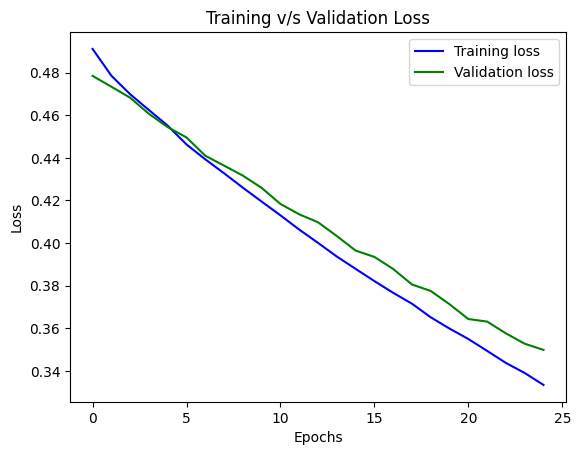

train_acc,▁▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████
train_loss,█▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁
val_acc,█▄▃▆▆▃▄▆▃▃▅▄▁▂▅▄▂▄▁▄▆▃▃▃▂
val_loss,██▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▁▁▁
train_acc,0.99547
train_loss,0.33344
val_acc,0.98341
val_loss,0.34987


In [ ]:
def save_checkpoint(scheduler, optimizer, model, loss_history, epoch, filename):
    checkpoint_dict = {
        'scheduler': scheduler.state_dict(),
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'loss_history': loss_history,
        'epoch': epoch
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(scheduler, optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint_dict['scheduler'])
    return checkpoint_dict['epoch'], checkpoint_dict['loss_history']


def plot_loss(loss_history, epochs):
    plt.plot(range(epochs), loss_history['train'], 'b', label='Training loss')
    plt.plot(range(epochs), loss_history['val'], 'g', label='Validation loss')
    plt.title('Training v/s Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


# Training function
def train_model(model, criterion, optimizer, scheduler, epochs=25,
                logging=False, checkpointing=False, resume_from_checkpoint=None):
    since = time.time()

    start = 0
    loss_history = defaultdict(list)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    min_loss = np.Inf
    epochs_no_improve = 0

    if resume_from_checkpoint:
        try:
            start, loss_history = load_checkpoint(scheduler, optimizer, model, resume_from_checkpoint)
        except FileNotFoundError:
            print('Checkpoint not found! Training from scratch...\n')
        except:
            print('Error loading checkpoint! Training from scratch...\n')

    if checkpointing:
        checkpoint_dir = root_dir+'checkpoints/LiNet/'
        os.makedirs(checkpoint_dir, exist_ok=True)
        print('Saving checkpoints in: '+checkpoint_dir)

    if logging:
        logs_dir = root_dir+'logs/LiNet/'
        os.makedirs(logs_dir, exist_ok=True)
        log_file_path = logs_dir+'LiNet-xxx-log.txt'
        log_file = open(log_file_path, 'w')
        print('Logging to: '+log_file_path)

    for epoch in range(start, epochs):
        print('\nEpoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)
        if logging:
            print('\nEpoch {}/{}'.format(epoch+1, epochs), file=log_file)
            print('-' * 10, file=log_file)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            num_images = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                num_images += inputs.size(0)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # sampling changes dataset size
            epoch_loss = running_loss / num_images
            epoch_acc = running_corrects.double() / num_images

            loss_history[phase].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase.capitalize(), epoch_loss, epoch_acc))
            if logging:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase.capitalize(), epoch_loss, epoch_acc), file=log_file)

            # Log to wandb
            wandb.log({
                phase+'_loss': epoch_loss,
                phase+'_acc': epoch_acc,
            }, step=epoch)

            # Adjust learning rate based on validation loss
            if phase == 'val':
                scheduler.step(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_loss < min_loss:
                min_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
                best_acc = epoch_acc
            elif phase == 'val' and epoch_loss >= min_loss:
                epochs_no_improve += 1
                if epochs_no_improve == 5:
                    time_elapsed = time.time() - since
                    print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                            time_elapsed // 60, time_elapsed % 60))
                    print('Best val Acc: {:4f}\n'.format(best_acc))
                    if logging:
                        print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                                time_elapsed // 60, time_elapsed % 60), file=log_file)
                        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
                    model.load_state_dict(best_model_wts)
                    return model, (loss_history, epoch+1)

        # save checkpoint
        if checkpointing:
            checkpoint_filename = checkpoint_dir+'LiNet-cp{:03d}.pkl'.format(epoch)
            save_checkpoint(scheduler, optimizer, model, loss_history, epoch, checkpoint_filename)
            if epoch > 2:
                prev_checkpoint = 'LiNet-cp{:03d}.pkl'.format(epoch-2)
                os.remove(checkpoint_dir+prev_checkpoint)

    time_elapsed = time.time() - since
    print('\nTraining complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}\n'.format(best_acc))
    if logging:
        print('\nTraining complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60), file=log_file)
        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
        log_file.close()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, (loss_history, epoch+1)

# Training the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-5, weight_decay=1e-5)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

net = net.to(device)
net, history = train_model(net, criterion, optimizer, scheduler, epochs=25,
                           logging=True, checkpointing=True)

plot_loss(*history)

# Finish the wandb session
wandb.finish()


In [15]:
class LiNet(nn.Module):
    def __init__(self):
        super(LiNet, self).__init__()
        self.features = nn.Sequential(OrderedDict([
                            ('conv0', nn.Conv2d(1, 6, 9)),
                            ('relu0', nn.ReLU()),
                            ('pool0', nn.AvgPool2d(2)),
                            ('bn0', nn.BatchNorm2d(6)),
                            ('conv1', nn.Conv2d(6, 12, 9)),
                            ('relu1', nn.ReLU()),
                            ('pool1', nn.AvgPool2d(2)),
                            ('bn1', nn.BatchNorm2d(12))
                        ]))
        self.classifier = nn.Sequential(OrderedDict([
                            ('fc0', nn.Linear(19 * 19 * 12, 100)),
                            ('relu', nn.ReLU()),
                            ('dropout', nn.Dropout(p=0.3)),
                            ('bn', nn.BatchNorm1d(100)),
                            ('fc1', nn.Linear(100, 3)),
                            ('softmax', nn.Softmax(dim=1)),
                            ('fc2', nn.Linear(3, 3))
                        ]))

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)  # Flatten the output
        out = self.classifier(out)
        return out
net = LiNet()

In [16]:
# Freeze the convolutional layers
for param in net.features.parameters():
    param.requires_grad = False


In [17]:
# Check if the convolutional layers are frozen
for name, param in net.named_parameters():
    if 'conv' in name:
        print(f'{name}: {param.requires_grad}')


features.conv0.weight: False
features.conv0.bias: False
features.conv1.weight: False
features.conv1.bias: False


In [18]:
state_dict = torch.load(root_dir+'<train1_model>.pth')
net.load_state_dict(state_dict)
net.eval()

<ipython-input-18-3c7b51214513>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(root_dir+'<train1_model>.pth')


LiNet(
  (features): Sequential(
    (conv0): Conv2d(1, 6, kernel_size=(9, 9), stride=(1, 1))
    (relu0): ReLU()
    (pool0): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (bn0): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(6, 12, kernel_size=(9, 9), stride=(1, 1))
    (relu1): ReLU()
    (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (fc0): Linear(in_features=4332, out_features=100, bias=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.3, inplace=False)
    (bn): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=100, out_features=3, bias=True)
    (softmax): Softmax(dim=1)
    (fc2): Linear(in_features=3, out_features=3, bias=True)
  )
)

In [19]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
        for x in ['train', 'test']}

data_sizes = {x: len(data[x]) for x in ['train', 'test']}
class_names = data['train'].classes
num_classes = len(class_names)

Saving checkpoints in: /content/gdrive/My Drive/checkpoints/LiNet/
Logging to: /content/gdrive/My Drive/logs/LiNet/LiNet-xxx-log.txt

Epoch 1/25
----------
Train Loss: 0.4906 Acc: 0.9818
Val Loss: 0.4829 Acc: 0.9831

Epoch 2/25
----------
Train Loss: 0.4794 Acc: 0.9857
Val Loss: 0.4739 Acc: 0.9846

Epoch 3/25
----------
Train Loss: 0.4703 Acc: 0.9874
Val Loss: 0.4670 Acc: 0.9851

Epoch 4/25
----------
Train Loss: 0.4616 Acc: 0.9889
Val Loss: 0.4618 Acc: 0.9850

Epoch 5/25
----------
Train Loss: 0.4536 Acc: 0.9895
Val Loss: 0.4558 Acc: 0.9832

Epoch 6/25
----------
Train Loss: 0.4458 Acc: 0.9908
Val Loss: 0.4502 Acc: 0.9835

Epoch 7/25
----------
Train Loss: 0.4394 Acc: 0.9906
Val Loss: 0.4416 Acc: 0.9841

Epoch 8/25
----------
Train Loss: 0.4320 Acc: 0.9917
Val Loss: 0.4352 Acc: 0.9844

Epoch 9/25
----------
Train Loss: 0.4261 Acc: 0.9919
Val Loss: 0.4314 Acc: 0.9833

Epoch 10/25
----------
Train Loss: 0.4199 Acc: 0.9916
Val Loss: 0.4237 Acc: 0.9856

Epoch 11/25
----------
Train Loss: 

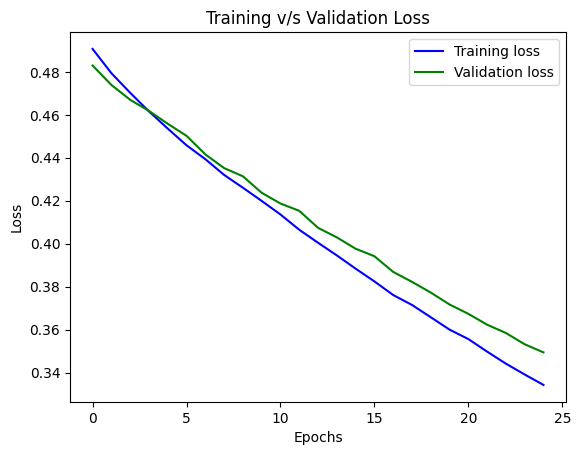

train_acc,▁▃▄▅▅▆▆▆▆▆▆▇▇▇▇▇█▇▇█▇████
train_loss,█▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁
val_acc,▃▆▇▇▃▄▅▆▃██▃▅▃▆▁▅▄▄▄▆▅▄▃▄
val_loss,██▇▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁▁
train_acc,0.9952
train_loss,0.33433
val_acc,0.98369
val_loss,0.34946


In [20]:
def save_checkpoint(scheduler, optimizer, model, loss_history, epoch, filename):
    checkpoint_dict = {
        'scheduler': scheduler.state_dict(),
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'loss_history': loss_history,
        'epoch': epoch
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(scheduler, optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint_dict['scheduler'])
    return checkpoint_dict['epoch'], checkpoint_dict['loss_history']


def plot_loss(loss_history, epochs):
    plt.plot(range(epochs), loss_history['train'], 'b', label='Training loss')
    plt.plot(range(epochs), loss_history['val'], 'g', label='Validation loss')
    plt.title('Training v/s Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


# Training function
def train_model(model, criterion, optimizer, scheduler, epochs=25,
                logging=False, checkpointing=False, resume_from_checkpoint=None):
    since = time.time()

    start = 0
    loss_history = defaultdict(list)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    min_loss = np.Inf
    epochs_no_improve = 0

    if resume_from_checkpoint:
        try:
            start, loss_history = load_checkpoint(scheduler, optimizer, model, resume_from_checkpoint)
        except FileNotFoundError:
            print('Checkpoint not found! Training from scratch...\n')
        except:
            print('Error loading checkpoint! Training from scratch...\n')

    if checkpointing:
        checkpoint_dir = root_dir+'checkpoints/LiNet/'
        os.makedirs(checkpoint_dir, exist_ok=True)
        print('Saving checkpoints in: '+checkpoint_dir)

    if logging:
        logs_dir = root_dir+'logs/LiNet/'
        os.makedirs(logs_dir, exist_ok=True)
        log_file_path = logs_dir+'LiNet-xxx-log.txt'
        log_file = open(log_file_path, 'w')
        print('Logging to: '+log_file_path)

    for epoch in range(start, epochs):
        print('\nEpoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)
        if logging:
            print('\nEpoch {}/{}'.format(epoch+1, epochs), file=log_file)
            print('-' * 10, file=log_file)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            num_images = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                num_images += inputs.size(0)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # sampling changes dataset size
            epoch_loss = running_loss / num_images
            epoch_acc = running_corrects.double() / num_images

            loss_history[phase].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase.capitalize(), epoch_loss, epoch_acc))
            if logging:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase.capitalize(), epoch_loss, epoch_acc), file=log_file)

            # Log to wandb
            wandb.log({
                phase+'_loss': epoch_loss,
                phase+'_acc': epoch_acc,
            }, step=epoch)

            # Adjust learning rate based on validation loss
            if phase == 'val':
                scheduler.step(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_loss < min_loss:
                min_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
                best_acc = epoch_acc
            elif phase == 'val' and epoch_loss >= min_loss:
                epochs_no_improve += 1
                if epochs_no_improve == 5:
                    time_elapsed = time.time() - since
                    print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                            time_elapsed // 60, time_elapsed % 60))
                    print('Best val Acc: {:4f}\n'.format(best_acc))
                    if logging:
                        print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                                time_elapsed // 60, time_elapsed % 60), file=log_file)
                        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
                    model.load_state_dict(best_model_wts)
                    return model, (loss_history, epoch+1)

        # save checkpoint
        if checkpointing:
            checkpoint_filename = checkpoint_dir+'LiNet-cp{:03d}.pkl'.format(epoch)
            save_checkpoint(scheduler, optimizer, model, loss_history, epoch, checkpoint_filename)
            if epoch > 2:
                prev_checkpoint = 'LiNet-cp{:03d}.pkl'.format(epoch-2)
                os.remove(checkpoint_dir+prev_checkpoint)

    time_elapsed = time.time() - since
    print('\nTraining complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}\n'.format(best_acc))
    if logging:
        print('\nTraining complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60), file=log_file)
        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
        log_file.close()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, (loss_history, epoch+1)

# Training the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-5, weight_decay=1e-5)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

net = net.to(device)
net, history = train_model(net, criterion, optimizer, scheduler, epochs=25,
                           logging=True, checkpointing=True)

plot_loss(*history)

# Finish the wandb session
wandb.finish()


# Train1_Depth

In [31]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, nin, nout):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin, 9, groups=nin)
        self.pointwise = nn.Conv2d(nin, nout, 1)
        self.bn_depthwise = nn.BatchNorm2d(nin)
        self.bn_pointwise = nn.BatchNorm2d(nout)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.depthwise(x)
        x = self.bn_depthwise(x)
        x = self.relu(x)
        x = self.pointwise(x)
        x = self.bn_pointwise(x)
        x = self.relu(x)
        return x

class LiNet(nn.Module):
    def __init__(self, num_classes=3):
        super(LiNet, self).__init__()
        self.features = nn.Sequential(OrderedDict([
            ('conv0', DepthwiseSeparableConv(1, 6)),
            ('pool0', nn.AvgPool2d(2)),
            ('conv1', DepthwiseSeparableConv(6, 12)),
            ('pool1', nn.AvgPool2d(2)),
        ]))
        self.classifier = nn.Sequential(OrderedDict([
            ('fc0', nn.Linear(19 * 19 * 12, 100)),
            ('relu', nn.ReLU()),
            ('bn', nn.BatchNorm1d(100)),
            ('fc1', nn.Linear(100, num_classes)),
            ('softmax', nn.Softmax(dim=1)),
        ]))

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.classifier(x)
        return x



net = LiNet()


# Calculate the total number of parameters
param_count = sum(p.numel() for p in net.parameters()) / 1000000
# Print the result in millions
print('\nTotal Parameter Count: %.2f M' % param_count)
# Calculate the number of parameters for the feature extractor only
feature_extractor_params = sum(p.numel() for p in net.features.parameters())
# Prit the result for feature extractor parameters
print('Feature Extractor Parameter Count: %d ' % feature_extractor_params)



Total Parameter Count: 0.43 M
Feature Extractor Parameter Count: 720 


In [ ]:
# To calculate the feature extractor parameters:

# For DepthwiseSeparableConv(1, 6) (conv0):
# 1. Depthwise Convolution:
#    - Number of weights = 1 * 9 * 9 = 81
#    - Number of biases = 1
#    - Total = 81 + 1 = 82

# 2. Pointwise Convolution:
#    - Number of weights = 1 * 6 = 6
#    - Number of biases = 6
#    - Total = 6 + 6 = 12

# 3. Batch Norm Layers:
#    - Depthwise BN (gamma + beta) = 1 * 2 = 2
#    - Pointwise BN (gamma + beta) = 6 * 2 = 12

# 4. Total for conv0:
#    - 82 + 12 + 2 + 12 = 108

conv0_depthwise_total = 82
conv0_pointwise_total = 12
conv0_bn_depthwise = 2
conv0_bn_pointwise = 12
conv0_total = 108

# For DepthwiseSeparableConv(6, 12) (conv1):
# 1. Depthwise Convolution:
#    - Number of weights = 6 * 9 * 9 = 486
#    - Number of biases = 6
#    - Total = 486 + 6 = 492

# 2. Pointwise Convolution:
#    - Number of weights = 6 * 12 = 72
#    - Number of biases = 12
#    - Total = 72 + 12 = 84

# 3. Batch Norm Layers:
#    - Depthwise BN (gamma + beta) = 6 * 2 = 12
#    - Pointwise BN (gamma + beta) = 12 * 2 = 24

# 4. Total for conv1:
#    - 492 + 84 + 12 + 24 = 612

conv1_depthwise_total = 492
conv1_pointwise_total = 84
conv1_bn_depthwise = 12
conv1_bn_pointwise = 24
conv1_total = 612

# Total Feature Extractor Parameters:
# Summing both layers:
# Feature Extractor Total Parameters = 108 + 612 = 720

feature_extractor_total = 720

We conclude that using a regular convolutional layer resulted in much higher parameters(6372.00), compared to using depth wise seperable convoltions(720). This demonstrates how depthwise separable convolutions reduce the number of parameters while maintaining representational power, making the model more efficient.


Saving checkpoints in: /content/gdrive/My Drive/checkpoints/LiNet/
Logging to: /content/gdrive/My Drive/logs/LiNet/LiNet-xxx-log.txt

Epoch 1/10
----------
Train Loss: 0.6766 Acc: 0.8954
Val Loss: 0.6570 Acc: 0.9038

Epoch 2/10
----------
Train Loss: 0.6068 Acc: 0.9558
Val Loss: 0.6506 Acc: 0.9039

Epoch 3/10
----------
Train Loss: 0.5869 Acc: 0.9731
Val Loss: 0.6503 Acc: 0.9035

Epoch 4/10
----------
Train Loss: 0.5775 Acc: 0.9801
Val Loss: 0.6325 Acc: 0.9230

Epoch 5/10
----------
Train Loss: 0.5710 Acc: 0.9856
Val Loss: 0.6404 Acc: 0.9167

Epoch 6/10
----------
Train Loss: 0.5656 Acc: 0.9889
Val Loss: 0.6343 Acc: 0.9180

Epoch 7/10
----------
Train Loss: 0.5638 Acc: 0.9903
Val Loss: 0.6424 Acc: 0.9068

Epoch 8/10
----------
Train Loss: 0.5630 Acc: 0.9910
Val Loss: 0.6351 Acc: 0.9160

Epoch 9/10
----------
Train Loss: 0.5619 Acc: 0.9918
Val Loss: 0.6356 Acc: 0.9133

Early stopping! Completed in 10m 48s
Best val Acc: 0.923049



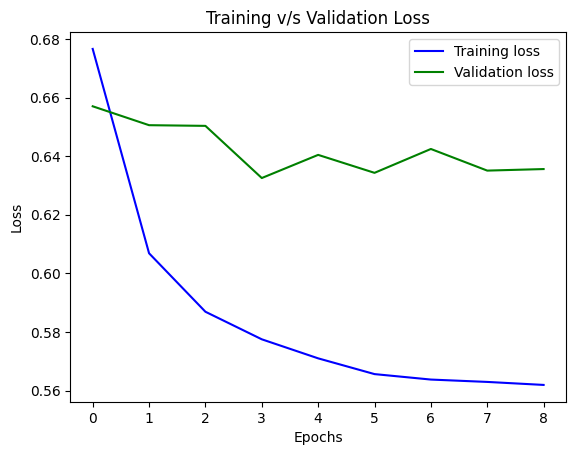

In [32]:
def save_checkpoint(scheduler, optimizer, model, loss_history, epoch, filename):
    checkpoint_dict = {
        'scheduler': scheduler.state_dict(),
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'loss_history': loss_history,
        'epoch': epoch
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(scheduler, optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint_dict['scheduler'])
    return checkpoint_dict['epoch'], checkpoint_dict['loss_history']


def plot_loss(loss_history, epochs):
    plt.plot(range(epochs), loss_history['train'], 'b', label='Training loss')
    plt.plot(range(epochs), loss_history['val'], 'g', label='Validation loss')
    plt.title('Training v/s Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def train_model(model, criterion, optimizer, scheduler, epochs=25,
                logging=False, checkpointing=False, resume_from_checkpoint=None):
    since = time.time()

    start = 0
    loss_history = defaultdict(list)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    min_loss = np.Inf
    epochs_no_improve = 0

    if resume_from_checkpoint:
        try:
            start, loss_history = load_checkpoint(scheduler, optimizer, model, resume_from_checkpoint)
        except FileNotFoundError:
            print('Checkpoint not found! Training from scratch...\n')
        except:
            print('Error loading checkpoint! Training from scratch...\n')

    if checkpointing:
        checkpoint_dir = root_dir + 'checkpoints/LiNet/'
        os.makedirs(checkpoint_dir, exist_ok=True)
        print('Saving checkpoints in: ' + checkpoint_dir)

    if logging:
        logs_dir = root_dir + 'logs/LiNet/'
        os.makedirs(logs_dir, exist_ok=True)
        log_file_path = logs_dir + 'LiNet-xxx-log.txt'
        log_file = open(log_file_path, 'w')
        print('Logging to: ' + log_file_path)

    for epoch in range(start, epochs):
        print('\nEpoch {}/{}'.format(epoch + 1, epochs))
        print('-' * 10)
        if logging:
            print('\nEpoch {}/{}'.format(epoch + 1, epochs), file=log_file)
            print('-' * 10, file=log_file)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            num_images = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                num_images += inputs.size(0)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            # sampling changes dataset size
            epoch_loss = running_loss / num_images
            epoch_acc = running_corrects.double() / num_images

            loss_history[phase].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase.capitalize(), epoch_loss, epoch_acc))
            if logging:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase.capitalize(), epoch_loss, epoch_acc), file=log_file)
            wandb.log({  # Use wandb.log directly
                phase + '_loss': epoch_loss,
                phase + '_acc': epoch_acc,
            }, step=epoch)

            # deep copy the model
            if phase == 'val' and epoch_loss < min_loss:
                min_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
                best_acc = epoch_acc
            elif phase == 'val' and epoch_loss >= min_loss:
                epochs_no_improve += 1
                if epochs_no_improve == 5:
                    time_elapsed = time.time() - since
                    print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                        time_elapsed // 60, time_elapsed % 60))
                    print('Best val Acc: {:4f}\n'.format(best_acc))
                    if logging:
                        print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                            time_elapsed // 60, time_elapsed % 60), file=log_file)
                        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
                    model.load_state_dict(best_model_wts)
                    return model, (loss_history, epoch + 1)

        # save checkpoint
        if checkpointing:
            checkpoint_filename = checkpoint_dir + 'LiNet-cp{:03d}.pkl'.format(epoch)
            save_checkpoint(scheduler, optimizer, model, loss_history, epoch, checkpoint_filename)
            if epoch > 2:
                prev_checkpoint = 'LiNet-cp{:03d}.pkl'.format(epoch - 2)
                os.remove(checkpoint_dir + prev_checkpoint)

    time_elapsed = time.time() - since
    print('\nTraining complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}\n'.format(best_acc))
    if logging:
        print('\nTraining complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60), file=log_file)
        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
        log_file.close()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, (loss_history, epoch + 1)


# Train the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-6)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

net = net.to(device)
net, history = train_model(net, criterion, optimizer, scheduler, epochs=10,
                           logging=True, checkpointing=True)

plot_loss(*history)


1. Class Imbalance:

Yes, class imbalance can affect model performance, particularly in classification tasks like ours. Models tend to be biased toward the majority class and underperform on minority classes.

# Train2_Depth

In [63]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, nin, nout):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin, 9, groups=nin)
        self.pointwise = nn.Conv2d(nin, nout, 1)
        self.bn_depthwise = nn.BatchNorm2d(nin)
        self.bn_pointwise = nn.BatchNorm2d(nout)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.bn_depthwise(x)
        x = self.relu(x)
        x = self.pointwise(x)
        x = self.bn_pointwise(x)
        x = self.relu(x)
        x = self.dropout(x)
        return x

class LiNet(nn.Module):
    def __init__(self, num_classes=3):
        super(LiNet, self).__init__()
        self.features = nn.Sequential(OrderedDict([
            ('conv0', DepthwiseSeparableConv(1, 6)),
            ('pool0', nn.AvgPool2d(2)),
            ('conv1', DepthwiseSeparableConv(6, 12)),
            ('pool1', nn.AvgPool2d(2)),
        ]))
        self.classifier = nn.Sequential(OrderedDict([
            ('fc0', nn.Linear(19 * 19 * 12, 100)),
            ('relu', nn.ReLU()),
            ('bn', nn.BatchNorm1d(100)),
            ('fc1', nn.Linear(100, num_classes)),
            ('softmax', nn.Softmax(dim=1)),
        ]))

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.classifier(x)
        return x



# Instantiate the model
net = LiNet()

In [45]:
state_dict = torch.load(root_dir+'<deptwise1_model>.pth')
net.load_state_dict(state_dict)
net.eval()

<ipython-input-45-5caea10b65fd>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(root_dir+'<deptwise1_model>.pth')


LiNet(
  (features): Sequential(
    (conv0): DepthwiseSeparableConv(
      (depthwise): Conv2d(1, 1, kernel_size=(9, 9), stride=(1, 1))
      (pointwise): Conv2d(1, 6, kernel_size=(1, 1), stride=(1, 1))
      (bn_depthwise): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_pointwise): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (pool0): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (conv1): DepthwiseSeparableConv(
      (depthwise): Conv2d(6, 6, kernel_size=(9, 9), stride=(1, 1), groups=6)
      (pointwise): Conv2d(6, 12, kernel_size=(1, 1), stride=(1, 1))
      (bn_depthwise): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_pointwise): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.3, inplace=False)
    )
  

In [46]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
        for x in ['train', 'test']}

data_sizes = {x: len(data[x]) for x in ['train', 'test']}
class_names = data['train'].classes
num_classes = len(class_names)

Saving checkpoints in: /content/gdrive/My Drive/checkpoints/LiNet/
Logging to: /content/gdrive/My Drive/logs/LiNet/LiNet-xxx-log.txt

Epoch 1/10
----------
Train Loss: 0.6107 Acc: 0.9481
Val Loss: 0.6569 Acc: 0.8972

Epoch 2/10
----------
Train Loss: 0.6026 Acc: 0.9561
Val Loss: 0.6566 Acc: 0.8957

Epoch 3/10
----------
Train Loss: 0.5998 Acc: 0.9591
Val Loss: 0.6474 Acc: 0.9083

Epoch 4/10
----------
Train Loss: 0.5968 Acc: 0.9621
Val Loss: 0.6436 Acc: 0.9101

Epoch 5/10
----------
Train Loss: 0.5943 Acc: 0.9640
Val Loss: 0.6376 Acc: 0.9187

Epoch 6/10
----------
Train Loss: 0.5933 Acc: 0.9656
Val Loss: 0.6403 Acc: 0.9171

Epoch 7/10
----------
Train Loss: 0.5907 Acc: 0.9679
Val Loss: 0.6425 Acc: 0.9133

Epoch 8/10
----------
Train Loss: 0.5902 Acc: 0.9681
Val Loss: 0.6349 Acc: 0.9193

Epoch 9/10
----------
Train Loss: 0.5886 Acc: 0.9699
Val Loss: 0.6424 Acc: 0.9109

Epoch 10/10
----------
Train Loss: 0.5868 Acc: 0.9716
Val Loss: 0.6325 Acc: 0.9224

Training complete in 12m 2s
Best va

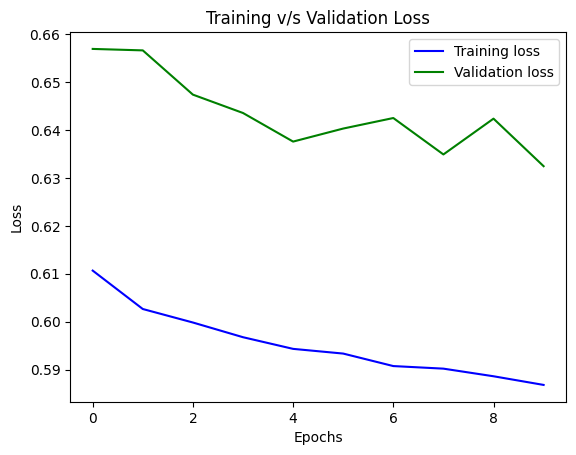

In [47]:
def save_checkpoint(scheduler, optimizer, model, loss_history, epoch, filename):
    checkpoint_dict = {
        'scheduler': scheduler.state_dict(),
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'loss_history': loss_history,
        'epoch': epoch
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(scheduler, optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint_dict['scheduler'])
    return checkpoint_dict['epoch'], checkpoint_dict['loss_history']


def plot_loss(loss_history, epochs):
    plt.plot(range(epochs), loss_history['train'], 'b', label='Training loss')
    plt.plot(range(epochs), loss_history['val'], 'g', label='Validation loss')
    plt.title('Training v/s Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def train_model(model, criterion, optimizer, scheduler, epochs=25,
                logging=False, checkpointing=False, resume_from_checkpoint=None):
    since = time.time()

    start = 0
    loss_history = defaultdict(list)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    min_loss = np.Inf
    epochs_no_improve = 0

    if resume_from_checkpoint:
        try:
            start, loss_history = load_checkpoint(scheduler, optimizer, model, resume_from_checkpoint)
        except FileNotFoundError:
            print('Checkpoint not found! Training from scratch...\n')
        except:
            print('Error loading checkpoint! Training from scratch...\n')

    if checkpointing:
        checkpoint_dir = root_dir + 'checkpoints/LiNet/'
        os.makedirs(checkpoint_dir, exist_ok=True)
        print('Saving checkpoints in: ' + checkpoint_dir)

    if logging:
        logs_dir = root_dir + 'logs/LiNet/'
        os.makedirs(logs_dir, exist_ok=True)
        log_file_path = logs_dir + 'LiNet-xxx-log.txt'
        log_file = open(log_file_path, 'w')
        print('Logging to: ' + log_file_path)

    for epoch in range(start, epochs):
        print('\nEpoch {}/{}'.format(epoch + 1, epochs))
        print('-' * 10)
        if logging:
            print('\nEpoch {}/{}'.format(epoch + 1, epochs), file=log_file)
            print('-' * 10, file=log_file)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            num_images = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                num_images += inputs.size(0)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Compute metrics
            epoch_loss = running_loss / num_images
            epoch_acc = running_corrects.double() / num_images
            loss_history[phase].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase.capitalize(), epoch_loss, epoch_acc))
            if logging:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase.capitalize(), epoch_loss, epoch_acc), file=log_file)

            # Adjust the learning rate based on validation loss
            if phase == 'val':
                scheduler.step(epoch_loss)

            # Save the best model weights
            if phase == 'val' and epoch_loss < min_loss:
                min_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
                best_acc = epoch_acc
            elif phase == 'val' and epoch_loss >= min_loss:
                epochs_no_improve += 1
                if epochs_no_improve == 5:
                    time_elapsed = time.time() - since
                    print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                        time_elapsed // 60, time_elapsed % 60))
                    print('Best val Acc: {:4f}\n'.format(best_acc))
                    if logging:
                        print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                            time_elapsed // 60, time_elapsed % 60), file=log_file)
                        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
                    model.load_state_dict(best_model_wts)
                    return model, (loss_history, epoch + 1)

        # Save checkpoint
        if checkpointing:
            checkpoint_filename = checkpoint_dir + 'LiNet-cp{:03d}.pkl'.format(epoch)
            save_checkpoint(scheduler, optimizer, model, loss_history, epoch, checkpoint_filename)
            if epoch > 2:
                prev_checkpoint = 'LiNet-cp{:03d}.pkl'.format(epoch - 2)
                os.remove(checkpoint_dir + prev_checkpoint)

    # Training completion
    time_elapsed = time.time() - since
    print('\nTraining complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}\n'.format(best_acc))
    if logging:
        print('\nTraining complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60), file=log_file)
        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
        log_file.close()

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, (loss_history, epoch + 1)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-5, weight_decay=1e-5)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

net = net.to(device)
net, history = train_model(net, criterion, optimizer, scheduler, epochs=10,
                           logging=True, checkpointing=True)

plot_loss(*history)




# Train3_Depth

In [ ]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, nin, nout):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin, 9, groups=nin)
        self.pointwise = nn.Conv2d(nin, nout, 1)
        self.bn_depthwise = nn.BatchNorm2d(nin)
        self.bn_pointwise = nn.BatchNorm2d(nout)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.bn_depthwise(x)
        x = self.relu(x)
        x = self.pointwise(x)
        x = self.bn_pointwise(x)
        x = self.relu(x)
        x = self.dropout(x)
        return x

class LiNet(nn.Module):
    def __init__(self, num_classes=3):
        super(LiNet, self).__init__()
        self.features = nn.Sequential(OrderedDict([
            ('conv0', DepthwiseSeparableConv(1, 6)),
            ('pool0', nn.AvgPool2d(2)),
            ('conv1', DepthwiseSeparableConv(6, 12)),
            ('pool1', nn.AvgPool2d(2)),
        ]))
        self.classifier = nn.Sequential(OrderedDict([
            ('fc0', nn.Linear(19 * 19 * 12, 100)),
            ('relu', nn.ReLU()),
            ('bn', nn.BatchNorm1d(100)),
            ('fc1', nn.Linear(100, num_classes)),
            ('softmax', nn.Softmax(dim=1)),
        ]))

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.classifier(x)
        return x



# Instantiate the model
net = LiNet()

In [49]:
state_dict = torch.load(root_dir+'<deptwise1_model>.pth')
net.load_state_dict(state_dict)
net.eval()

<ipython-input-49-5caea10b65fd>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(root_dir+'<deptwise1_model>.pth')


LiNet(
  (features): Sequential(
    (conv0): DepthwiseSeparableConv(
      (depthwise): Conv2d(1, 1, kernel_size=(9, 9), stride=(1, 1))
      (pointwise): Conv2d(1, 6, kernel_size=(1, 1), stride=(1, 1))
      (bn_depthwise): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_pointwise): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (pool0): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (conv1): DepthwiseSeparableConv(
      (depthwise): Conv2d(6, 6, kernel_size=(9, 9), stride=(1, 1), groups=6)
      (pointwise): Conv2d(6, 12, kernel_size=(1, 1), stride=(1, 1))
      (bn_depthwise): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_pointwise): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.3, inplace=False)
    )
  

In [51]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
        for x in ['train', 'test']}

data_sizes = {x: len(data[x]) for x in ['train', 'test']}
class_names = data['train'].classes
num_classes = len(class_names)

Saving checkpoints in: /content/gdrive/My Drive/checkpoints/LiNet/
Logging to: /content/gdrive/My Drive/logs/LiNet/LiNet-xxx-log.txt

Epoch 1/25
----------
Train Loss: 0.6049 Acc: 0.9533
Val Loss: 0.6437 Acc: 0.9099

Epoch 2/25
----------
Train Loss: 0.5954 Acc: 0.9631
Val Loss: 0.6367 Acc: 0.9190

Epoch 3/25
----------
Train Loss: 0.5893 Acc: 0.9690
Val Loss: 0.6347 Acc: 0.9185

Epoch 4/25
----------
Train Loss: 0.5846 Acc: 0.9733
Val Loss: 0.6239 Acc: 0.9299

Epoch 5/25
----------
Train Loss: 0.5816 Acc: 0.9758
Val Loss: 0.6306 Acc: 0.9241

Epoch 6/25
----------
Train Loss: 0.5787 Acc: 0.9788
Val Loss: 0.6219 Acc: 0.9321

Epoch 7/25
----------
Train Loss: 0.5769 Acc: 0.9801
Val Loss: 0.6276 Acc: 0.9270

Epoch 8/25
----------
Train Loss: 0.5750 Acc: 0.9813
Val Loss: 0.6213 Acc: 0.9315

Epoch 9/25
----------
Train Loss: 0.5726 Acc: 0.9837
Val Loss: 0.6165 Acc: 0.9348

Epoch 10/25
----------
Train Loss: 0.5715 Acc: 0.9843
Val Loss: 0.6309 Acc: 0.9213

Epoch 11/25
----------
Train Loss: 

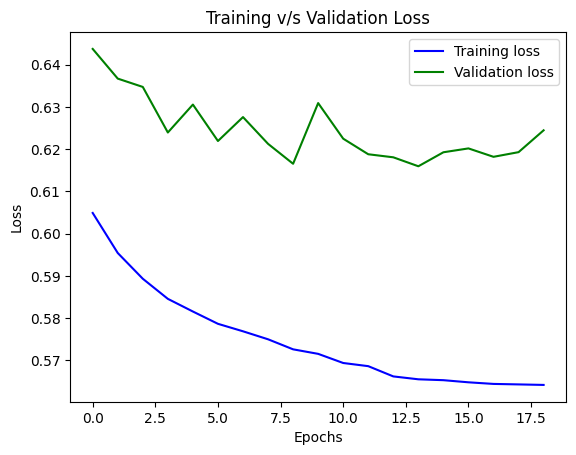

In [52]:
def save_checkpoint(scheduler, optimizer, model, loss_history, epoch, filename):
    checkpoint_dict = {
        'scheduler': scheduler.state_dict(),
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'loss_history': loss_history,
        'epoch': epoch
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(scheduler, optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint_dict['scheduler'])
    return checkpoint_dict['epoch'], checkpoint_dict['loss_history']


def plot_loss(loss_history, epochs):
    plt.plot(range(epochs), loss_history['train'], 'b', label='Training loss')
    plt.plot(range(epochs), loss_history['val'], 'g', label='Validation loss')
    plt.title('Training v/s Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def train_model(model, criterion, optimizer, scheduler, epochs=25,
                logging=False, checkpointing=False, resume_from_checkpoint=None):
    since = time.time()

    start = 0
    loss_history = defaultdict(list)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    min_loss = np.Inf
    epochs_no_improve = 0

    if resume_from_checkpoint:
        try:
            start, loss_history = load_checkpoint(scheduler, optimizer, model, resume_from_checkpoint)
        except FileNotFoundError:
            print('Checkpoint not found! Training from scratch...\n')
        except:
            print('Error loading checkpoint! Training from scratch...\n')

    if checkpointing:
        checkpoint_dir = root_dir + 'checkpoints/LiNet/'
        os.makedirs(checkpoint_dir, exist_ok=True)
        print('Saving checkpoints in: ' + checkpoint_dir)

    if logging:
        logs_dir = root_dir + 'logs/LiNet/'
        os.makedirs(logs_dir, exist_ok=True)
        log_file_path = logs_dir + 'LiNet-xxx-log.txt'
        log_file = open(log_file_path, 'w')
        print('Logging to: ' + log_file_path)

    for epoch in range(start, epochs):
        print('\nEpoch {}/{}'.format(epoch + 1, epochs))
        print('-' * 10)
        if logging:
            print('\nEpoch {}/{}'.format(epoch + 1, epochs), file=log_file)
            print('-' * 10, file=log_file)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            num_images = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                num_images += inputs.size(0)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Compute metrics
            epoch_loss = running_loss / num_images
            epoch_acc = running_corrects.double() / num_images
            loss_history[phase].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase.capitalize(), epoch_loss, epoch_acc))
            if logging:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase.capitalize(), epoch_loss, epoch_acc), file=log_file)

            # Adjust the learning rate based on validation loss
            if phase == 'val':
                scheduler.step(epoch_loss)

            # Save the best model weights
            if phase == 'val' and epoch_loss < min_loss:
                min_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
                best_acc = epoch_acc
            elif phase == 'val' and epoch_loss >= min_loss:
                epochs_no_improve += 1
                if epochs_no_improve == 5:
                    time_elapsed = time.time() - since
                    print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                        time_elapsed // 60, time_elapsed % 60))
                    print('Best val Acc: {:4f}\n'.format(best_acc))
                    if logging:
                        print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                            time_elapsed // 60, time_elapsed % 60), file=log_file)
                        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
                    model.load_state_dict(best_model_wts)
                    return model, (loss_history, epoch + 1)

        # Save checkpoint
        if checkpointing:
            checkpoint_filename = checkpoint_dir + 'LiNet-cp{:03d}.pkl'.format(epoch)
            save_checkpoint(scheduler, optimizer, model, loss_history, epoch, checkpoint_filename)
            if epoch > 2:
                prev_checkpoint = 'LiNet-cp{:03d}.pkl'.format(epoch - 2)
                os.remove(checkpoint_dir + prev_checkpoint)

    # Training completion
    time_elapsed = time.time() - since
    print('\nTraining complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}\n'.format(best_acc))
    if logging:
        print('\nTraining complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60), file=log_file)
        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
        log_file.close()

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, (loss_history, epoch + 1)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=5e-5, weight_decay=5e-5)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

net = net.to(device)
net, history = train_model(net, criterion, optimizer, scheduler, epochs=25,
                           logging=True, checkpointing=True)

plot_loss(*history)




# Evaluate

In [68]:
state_dict = torch.load(root_dir+'<train6_model>.pth')   #This is Train3 pre-trained model
net.load_state_dict(state_dict)
net.eval()

<ipython-input-68-37f7381bbb78>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(root_dir+'<train6_model>.pth')


LiNet(
  (features): Sequential(
    (conv0): Conv2d(1, 6, kernel_size=(9, 9), stride=(1, 1))
    (relu0): ReLU()
    (pool0): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (bn0): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(6, 12, kernel_size=(9, 9), stride=(1, 1))
    (relu1): ReLU()
    (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (fc0): Linear(in_features=4332, out_features=100, bias=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.3, inplace=False)
    (bn): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=100, out_features=3, bias=True)
    (softmax): Softmax(dim=1)
    (fc2): Linear(in_features=3, out_features=3, bias=True)
  )
)

In [69]:
def evaluate_model(model, classes, dataloader, out_file_path='accuracy.txt'):
    model.cpu()
    num_classes = len(classes)
    correct = 0
    total = 0
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))
    y_true = torch.ByteTensor()
    y_pred = torch.ByteTensor()

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == labels).squeeze()
            num_labels = labels.size(0)
            total += num_labels
            correct += c.sum().item()
            for i in range(num_labels):         # current batch size
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            y_true = torch.cat((y_true,labels), 0)
            y_pred = torch.cat((y_pred,predicted), 0)

    with open(out_file_path, "w") as out_file:
        print('Accuracy of the network on %d test images: %.4f%%'
              %(len(y_true), 100*correct/total))
        print('Accuracy of the network on %d test images: %.4f%%'
              %(len(y_true), 100*correct/total), file=out_file)
        for i in range(num_classes):
            print('\tAccuracy of %s : %.4f%%'
                  %(classes[i], 100*class_correct[i]/class_total[i]))
            print('\tAccuracy of %s : %.4f%%'
                  %(classes[i], 100*class_correct[i]/class_total[i]),
                  file=out_file)
        print("\nKappa Score: %.4f" %(cohen_kappa_score(y_true,y_pred)))
        print("\nKappa Score: %.4f" %(cohen_kappa_score(y_true,y_pred)),
              file=out_file)
        print('\n',classification_report(y_true, y_pred, target_names=class_names))
        print('\n',classification_report(y_true, y_pred, target_names=class_names),
              file=out_file)


!mkdir -p "$root_dir""logs/LiNet/"
out_file_path = root_dir+"logs/LiNet/LiNet-xxx-accuracy.txt"
evaluate_model(net, class_names, dataloaders['test'] if mode=='train' else test_dataloader, out_file_path)

Accuracy of the network on 2362 test images: 68.5013%
	Accuracy of corridor : 0.0000%
	Accuracy of door : 0.5952%
	Accuracy of room : 100.0000%

Kappa Score: 0.0022

               precision    recall  f1-score   support

    corridor       0.00      0.00      0.00       577
        door       1.00      0.01      0.01       168
        room       0.68      1.00      0.81      1617

    accuracy                           0.69      2362
   macro avg       0.56      0.34      0.27      2362
weighted avg       0.54      0.69      0.56      2362



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

# Estimate the Inference Speed

In [46]:
def get_fps(model, dataloader, reps=10):
    model.to(device)
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            batch_size = inputs.shape[0]

            # GPU warmup
            if device == 'cuda':
                for _ in range(10):
                    _ = model(inputs)
                torch.cuda.synchronize()

            start = time.time()
            for i in range(reps):
                _ = model(inputs)
            if device == 'cuda':
                torch.cuda.synchronize()
            end = time.time()
            elapsed_time = (end-start)
            inference_speed = elapsed_time / (reps * batch_size)
            throughput = (reps * batch_size) / elapsed_time
            break
    print('Inference speed: %.4f s' % inference_speed)
    print('Throughput: %d images' % throughput)

get_fps(net, dataloaders['test'] if mode=='train' else test_dataloader)

Inference speed: 0.0000 s
Throughput: 163995 images


# Make Predictions

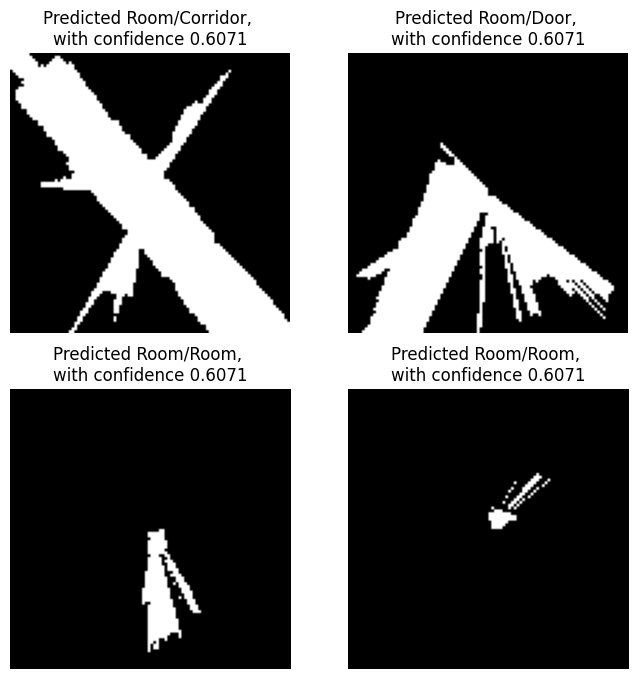

In [49]:
def predict(model, dataloader, num_images=4):
    was_training = model.training
    model.eval()
    model.to(device)
    images_so_far = 0
    fig = plt.figure(figsize=(8,8))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)                      # batch x channel x width x height
            labels = labels.to(device)

            outputs = model(inputs)                         # batch x classes
            prob = nn.functional.softmax(outputs, dim=-1)
            prob, idx = prob.sort(1,True)                   # batch x classes

            for j in range(inputs.size()[0]):
                images_so_far += 1
                if num_images == 1:
                    ax = plt.subplot(1, 1, 1)
                else:
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('Predicted {1}/{2}, \nwith confidence {0:.4f}'.format(prob[j][0],
                    class_names[idx[j][0]].capitalize(), class_names[labels[j]].capitalize()))
                ax.imshow(inputs.cpu().data[j].squeeze(), cmap='gray')

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


predict(net, dataloaders['test'] if mode=='train' else test_dataloader)

# Visualize Filters (Features) and Activations (Feature Maps)

In [50]:
def get_convs(layers):
    conv_layers = []
    for module in layers:
        if 'Conv2d' in str(type(module)):
            conv_layers.append(module)
        elif type(module)==nn.Sequential:
            conv_layers.extend(get_convs(module.children()))
    return conv_layers

convs = get_convs(net.features)
for conv in convs:
    print(f'CONV: {conv} => SHAPE: {conv.weight.shape}')

CONV: Conv2d(1, 6, kernel_size=(9, 9), stride=(1, 1)) => SHAPE: torch.Size([6, 1, 9, 9])
CONV: Conv2d(6, 12, kernel_size=(9, 9), stride=(1, 1)) => SHAPE: torch.Size([12, 6, 9, 9])


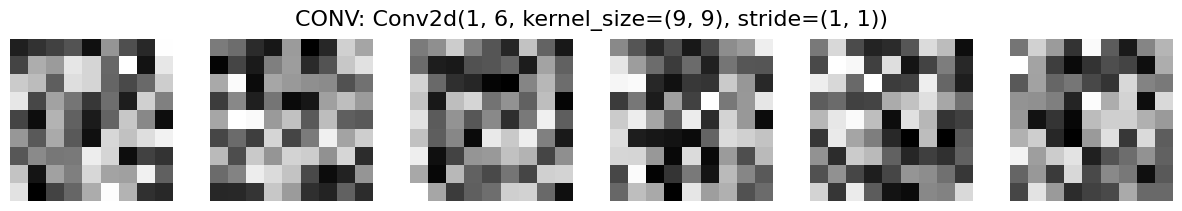

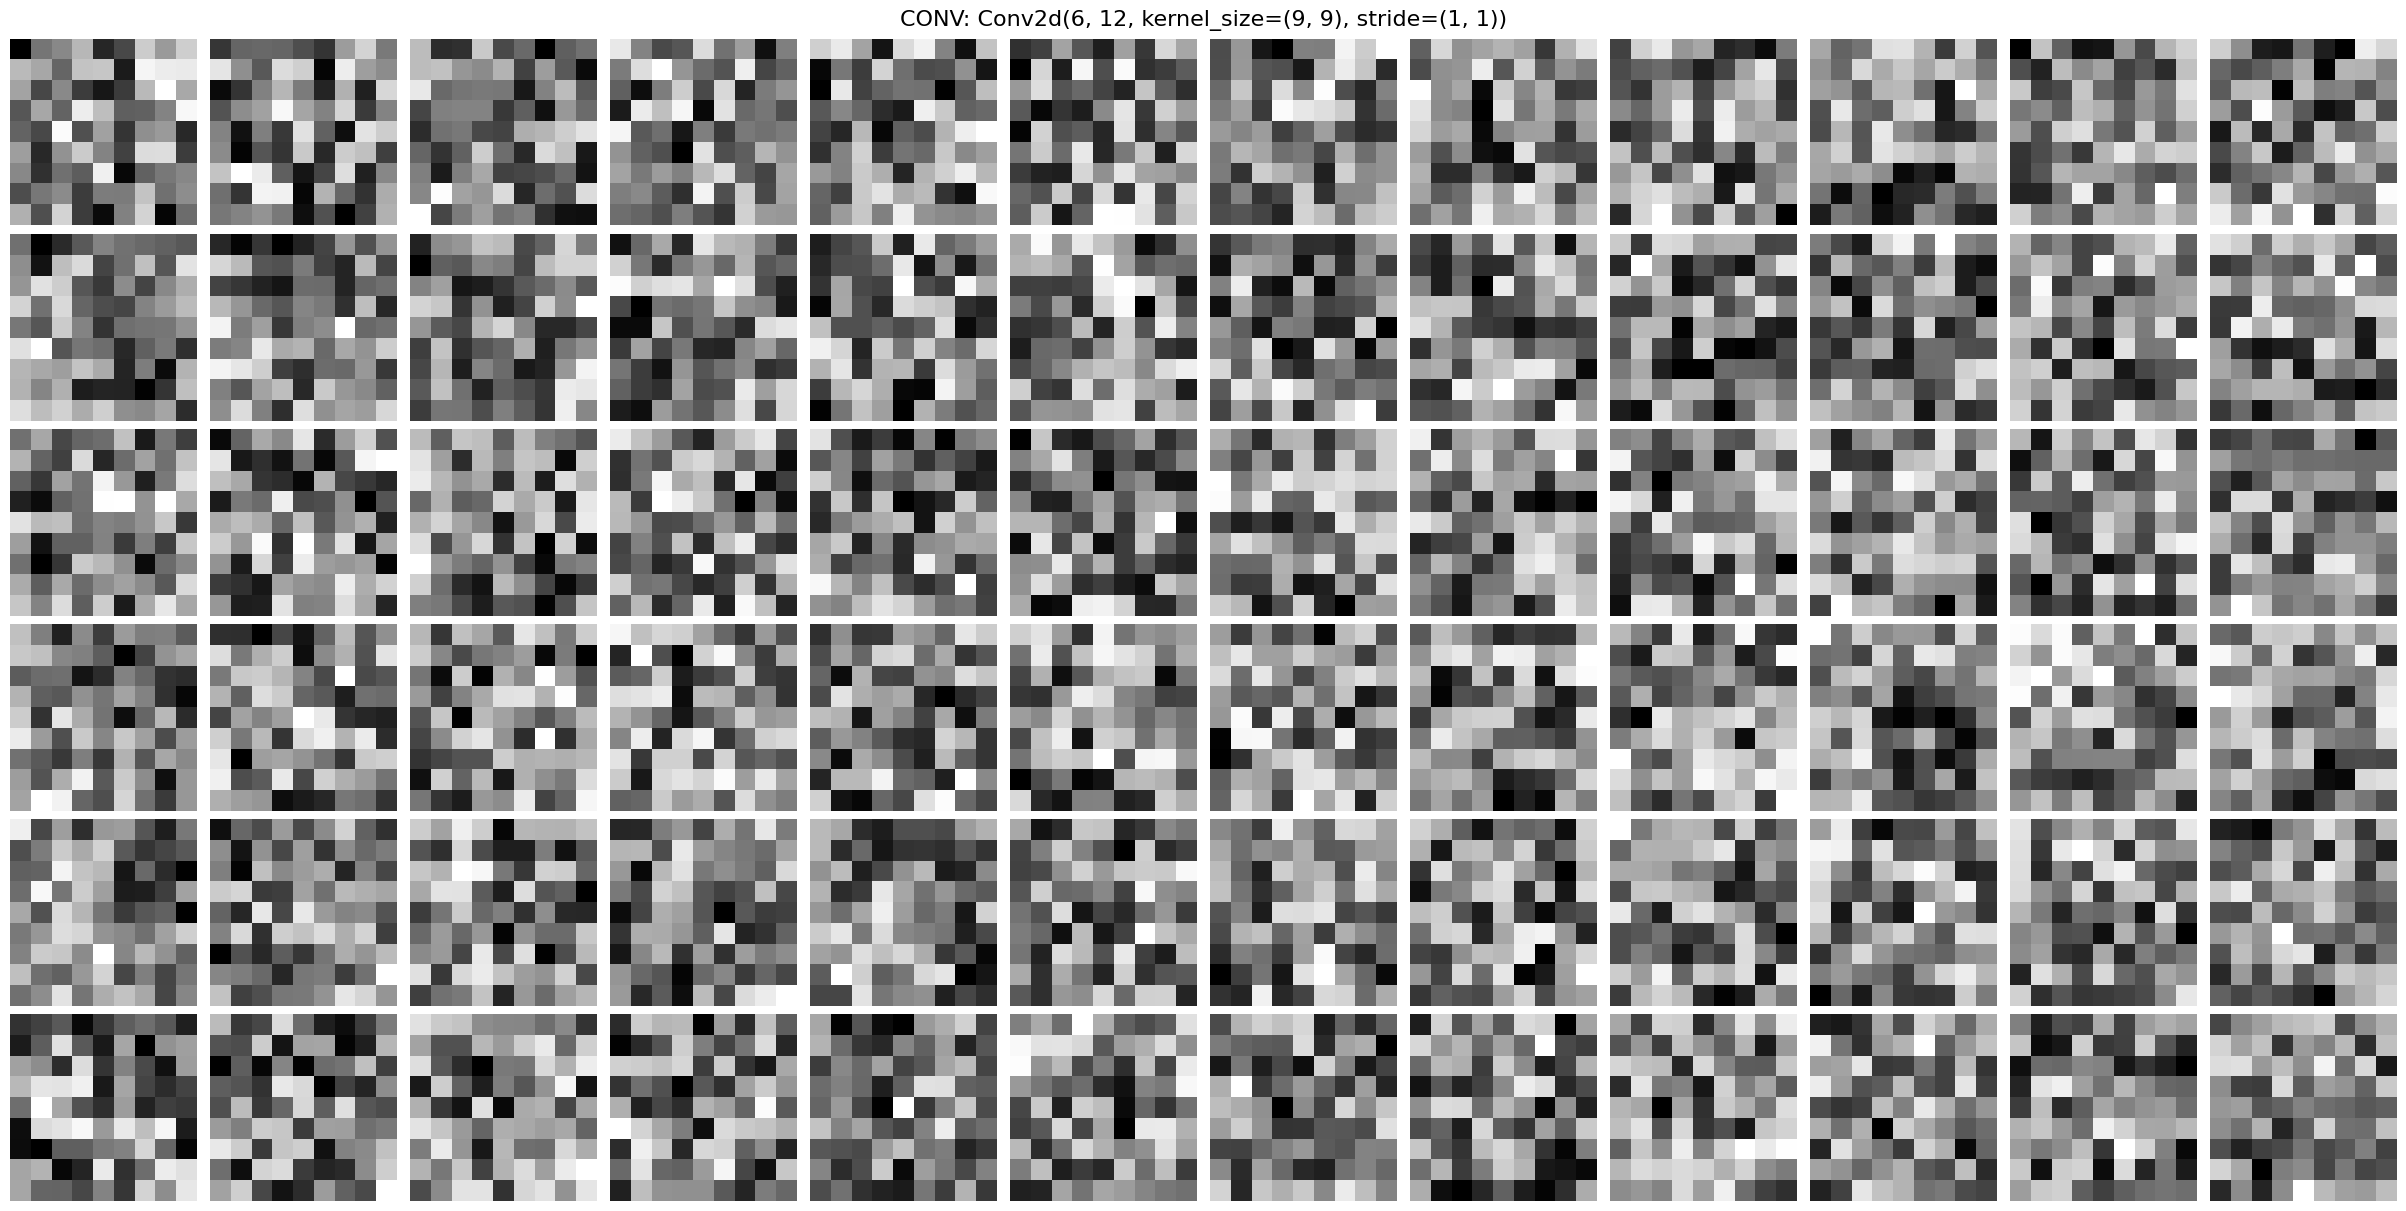

In [51]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_filters(convs):
    for conv in convs:
        # Extract filter weights and ensure they're on the CPU
        filters = conv.weight.detach().cpu().numpy()  # Shape: [out_channels, in_channels, kernel_size, kernel_size]
        out_ch, in_ch, k_h, k_w = filters.shape

        # Create a grid of subplots
        fig, axes = plt.subplots(in_ch, out_ch, figsize=(out_ch * 2, in_ch * 2), constrained_layout=True)
        fig.suptitle(f'CONV: {conv}', size=16)

        # Ensure axes is a 2D array for uniform access
        if in_ch == 1 or out_ch == 1:
            axes = np.atleast_2d(axes)

        # Plot each filter
        for i in range(in_ch):
            for j in range(out_ch):
                ax = axes[i, j]
                ax.imshow(filters[j, i], cmap='gray')  # Plot the filter (j: output, i: input)
                ax.axis('off')

        plt.show()


  # Example: Visualize filters from a model
conv_layers = [layer for layer in net.modules() if isinstance(layer, torch.nn.Conv2d)]
visualize_filters(conv_layers)


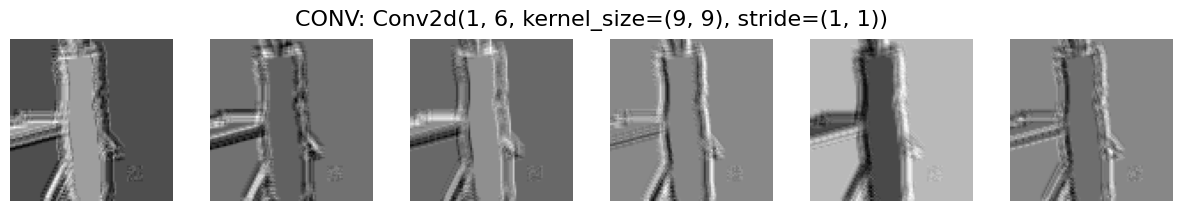

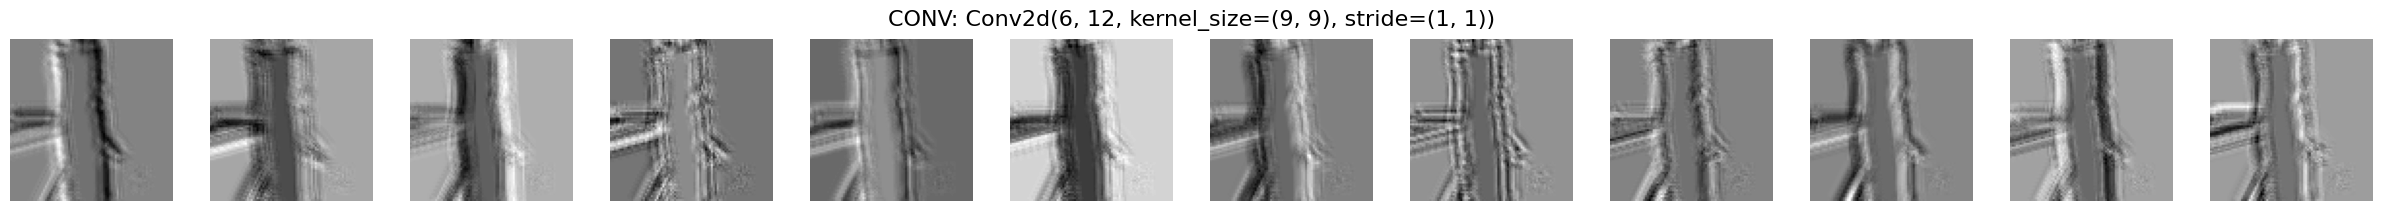

In [52]:
def visualize_activations(convs, dataloader):
    for inputs, labels in dataloader:
        inputs = inputs.to(device)  # B x C x H x W
        img = inputs[:1]

        activations = [convs[0](img)]
        for i in range(1, len(convs)):
            activations.append(convs[i](activations[-1]))

        for conv, act in zip(convs, activations):
            out_ch = conv.out_channels
            fig = plt.figure(figsize=(out_ch*2, 2), constrained_layout=True)
            fig.suptitle(f'CONV: {conv}', size=16)
            for j in range(out_ch):
                ax = plt.subplot(1, out_ch, j+1)
                ax.axis('off')
                ax.imshow(act.detach().squeeze()[j].cpu(), cmap='gray')
                # Dim --> B x Out Ch x H' x W'
        return


visualize_activations(convs, dataloaders['test'] if mode=='train' else test_dataloader)

# Visualize Grad-CAMs

<ipython-input-53-72d473e51b58>:10: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


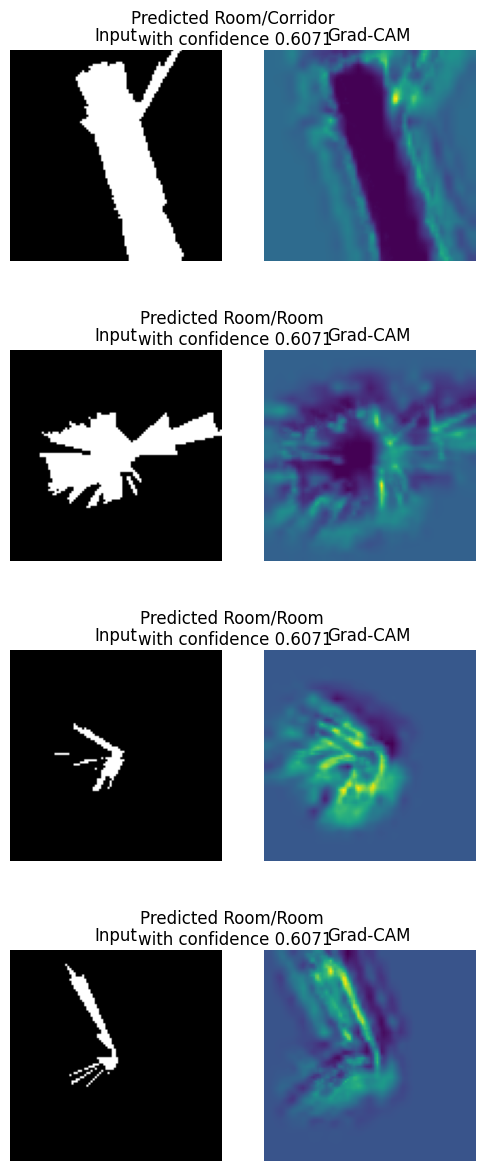

In [53]:
def visualize(model, dataloader, num_images=4):
    was_training = model.training
    model.eval()
    model.to(device)
    images_so_far = 0

    cam = GradCAM(model=model, target_layers=model.features)

    fig = plt.figure(constrained_layout=True, figsize=(6,12))
    fig.tight_layout()
    subfigs = fig.subfigures(nrows=num_images, ncols=1)

    for inputs, labels in dataloader:
        inputs = inputs.to(device)                      # B x C x W x H
        labels = labels.to(device)

        outputs = model(inputs)                         # B x classes
        prob = nn.functional.softmax(outputs, dim=-1)
        prob, idx = prob.sort(1,True)                   # B x classes

        masks = cam(input_tensor=inputs[:num_images])

        for j in range(inputs.size()[0]):
            axs = subfigs[j].subplots(1, 2)
            subfigs[j].suptitle('Predicted {1}/{2} \nwith confidence {0:.4f}'.format(prob[j][0],
                class_names[idx[j][0]].capitalize(), class_names[labels[j]].capitalize()))
            axs[0].axis('off')
            axs[0].set_title('Input')
            axs[0].imshow(inputs[j].cpu().squeeze(), cmap='gray')
            axs[1].axis('off')
            axs[1].set_title('Grad-CAM')
            axs[1].imshow(masks[j])

            images_so_far += 1
            if images_so_far == num_images:
                model.train(mode=was_training)
                return

    model.train(mode=was_training)


visualize(net, dataloaders['test'] if mode=='train' else test_dataloader)

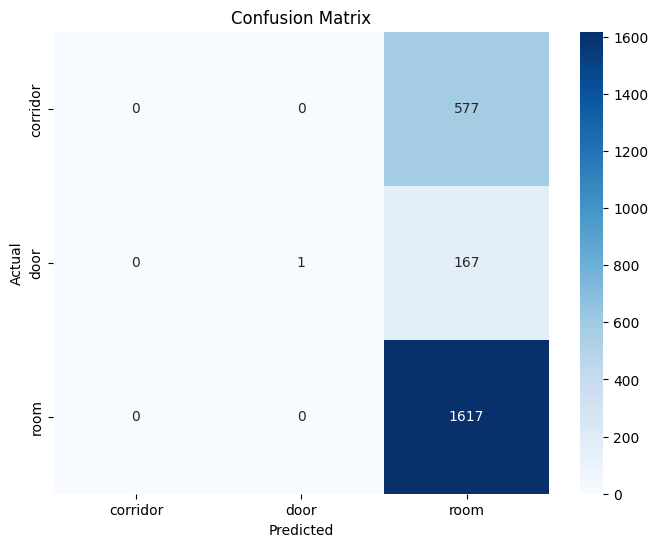

In [56]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.utils.data import DataLoader

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Assuming `net` is your trained model and `test_dataloader` is your test data loader
# Get predictions and actual labels
all_preds = []
all_labels = []

# Set model to evaluation mode
net.eval()

with torch.no_grad():
    for inputs, labels in test_dataloader:  # using test_dataloader here
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Get class names
class_names = test_dataloader.dataset.classes  # using test_dataloader here

# Plot the confusion matrix
plot_confusion_matrix(cm, class_names)


#Save the Trained Model

In [ ]:
torch.save(net.state_dict(),root_dir+'<train1_model>.pth')

with open(root_dir+'LiNet_categoryIndex.csv','w',newline='') as categoryIndexFile:
    categoryIndexWriter = csv.writer(categoryIndexFile, delimiter='\t')
    categoryIndexWriter.writerows(enumerate(class_names))
categoryIndexFile.close()

In [ ]:
torch.save(net.state_dict(),root_dir+'<train2_model>.pth')

with open(root_dir+'LiNet_categoryIndex.csv','w',newline='') as categoryIndexFile:
    categoryIndexWriter = csv.writer(categoryIndexFile, delimiter='\t')
    categoryIndexWriter.writerows(enumerate(class_names))
categoryIndexFile.close()

In [ ]:
torch.save(net.state_dict(),root_dir+'<train3_model>.pth')

with open(root_dir+'LiNet_categoryIndex.csv','w',newline='') as categoryIndexFile:
    categoryIndexWriter = csv.writer(categoryIndexFile, delimiter='\t')
    categoryIndexWriter.writerows(enumerate(class_names))
categoryIndexFile.close()

In [33]:
torch.save(net.state_dict(),root_dir+'<deptwise1_model>.pth')

with open(root_dir+'LiNet_categoryIndex.csv','w',newline='') as categoryIndexFile:
    categoryIndexWriter = csv.writer(categoryIndexFile, delimiter='\t')
    categoryIndexWriter.writerows(enumerate(class_names))
categoryIndexFile.close()

In [48]:
torch.save(net.state_dict(),root_dir+'<deptwise2_model>.pth')

with open(root_dir+'LiNet_categoryIndex.csv','w',newline='') as categoryIndexFile:
    categoryIndexWriter = csv.writer(categoryIndexFile, delimiter='\t')
    categoryIndexWriter.writerows(enumerate(class_names))
categoryIndexFile.close()